# Dogs vs Cats using PyTorch

## What is PyTorch?

* The initial release of PyTorch was in October 2016 to provide a flexible platform for researchers.
* A Torch based in Python
* The previous Torch was developed in 2009-2010 using Lue programming language. Torch design was aging. Difficult to debug. Painful to use. 

## Deep Learning specific features of PyTorch

* Programming neural network and deep learning require the use of tensor.
* If we want a rich framework, definitely we need more than tensor. 
* PyTorch gives more than that. 

## Working with PyTorch

### PyTorch Packages

* torch package – for top level PyTorch package and tensor library
* torch.nn – where neural networks are built. Contains classes like weight and layers 
* torch.autogra – handle derivative calculation to optimise neural network weight
* torch.nn.functional – typical deep learning function like loss functions, activation functions and convolutional operations.
* torch.optim – typical optimisation algorithm like SGD and Adam
* torch.utils – contains utility classes for data pre-processing.
* torchvision – for computer vision.


### Computational Graph

* Computational Graphs to compute the derivatives needed to optimise neural network weight.
* PyTorch using a dynamic computational graph. The graph is created on the fly.


### CUDA

* CUDA support multiple GPU.
* This ability make the PyTorch very versatile. 
* Support computing capabilities.


In [31]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()  

print(torch.cuda.current_device())
print(torch.cuda.get_device_name(0))
device = torch.device('cpu')
print(device)

0
Quadro P2000
cpu


In [32]:
print(torch.__version__)

1.4.0


In [33]:
data_dir = 'cat_dog_ex'
TRAIN = 'train'
VAL = 'val'
TEST = 'test'

# VGG-16 Takes 224x224 images as input, so we resize all of them
data_transforms = {
    TRAIN: transforms.Compose([
        # Data augmentation is a good practice for the train set
        # Here, we randomly crop the image to 224x224 and
        # randomly flip it horizontally. 
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]),
    VAL: transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]),
    TEST: transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ])
}

image_datasets = {
    x: datasets.ImageFolder(
        os.path.join(data_dir, x), 
        transform=data_transforms[x]
    )
    for x in [TRAIN, VAL, TEST]
}

dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], batch_size=8,
        shuffle=True, num_workers=4
    )
    for x in [TRAIN, VAL, TEST]
}

dataset_sizes = {x: len(image_datasets[x]) for x in [TRAIN, VAL, TEST]}

for x in [TRAIN, VAL, TEST]:
    print("Loaded {} images under {}".format(dataset_sizes[x], x))
    
print("Classes: ")
class_names = image_datasets[TRAIN].classes
print(image_datasets[TRAIN].classes)

Loaded 600 images under train
Loaded 200 images under val
Loaded 200 images under test
Classes: 
['cats', 'dogs']


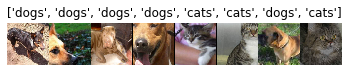

In [34]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    # plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# Get a batch of training data
inputs, classes = next(iter(dataloaders[TRAIN]))
show_databatch(inputs, classes)

In [35]:
def visualize_model(vgg, num_images=6):
    was_training = vgg.training
    
    # Set model for evaluation
    vgg.train(False)
    vgg.eval() 
    
    images_so_far = 0

    for i, data in enumerate(dataloaders[TEST]):
        inputs, labels = data
        size = inputs.size()[0]
        
        #if use_gpu:
            #inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)            
        #    inputs, labels = torch.as_tensor(inputs.cuda()), torch.as_tensor(labels.cuda())
        #else:            
            #inputs, labels = Variable(inputs, volatile=True), Variable(labels, volatile=True)
        inputs, labels = torch.as_tensor(inputs), torch.as_tensor(labels)
        
        outputs = vgg(inputs)
        
        _, preds = torch.max(outputs.data, 1)
        predicted_labels = [preds[j] for j in range(inputs.size()[0])]
        
        print("Ground truth:")
        show_databatch(inputs.data.cpu(), labels.data.cpu())
        print("Prediction:")
        show_databatch(inputs.data.cpu(), predicted_labels)
        
        del inputs, labels, outputs, preds, predicted_labels
        torch.cuda.empty_cache()
        
        images_so_far += size
        if images_so_far >= num_images:
            break
    vgg.train(mode=was_training) # Revert model back to original training state

In [36]:
def eval_model(vgg, criterion):
    since = time.time()
    avg_loss = 0
    avg_acc = 0
    loss_test = 0
    acc_test = 0
    
    test_batches = len(dataloaders[TEST])
    print("Evaluating model")
    print('-' * 10)
    
    for i, data in enumerate(dataloaders[TEST]):
        if i % 100 == 0:
            print("\rTest batch {}/{}".format(i, test_batches), end='', flush=True)

        vgg.train(False)
        vgg.eval()
        inputs, labels = data

        #if use_gpu:
            #inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)
        #    inputs, labels = torch.as_tensor(inputs.cuda()), torch.as_tensor(labels.cuda())
            
        #else:
            #inputs, labels = Variable(inputs, volatile=True), Variable(labels, volatile=True)
        inputs, labels = torch.as_tensor(inputs), torch.as_tensor(labels)

        outputs = vgg(inputs)

        _, preds = torch.max(outputs.data, 1)
        loss = criterion(outputs, labels)
        loss_test += loss.data
        acc_test += torch.sum(preds == labels.data)

        del inputs, labels, outputs, preds
        torch.cuda.empty_cache()
        
    avg_loss = loss_test / dataset_sizes[TEST]
    avg_acc = acc_test / dataset_sizes[TEST]
    
    elapsed_time = time.time() - since
    print()
    print("Evaluation completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Avg loss (test): {:.4f}".format(avg_loss))
    print("Avg acc (test): {:.4f}".format(avg_acc))
    print('-' * 10)

In [37]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16_bn()
vgg16.load_state_dict(torch.load("vgg16_bn.pth"))
print(vgg16.classifier[6].out_features) # 1000 


# Freeze training for all layers
for param in vgg16.features.parameters():
    param.require_grad = False

# Newly created modules have require_grad=True by default
num_features = vgg16.classifier[6].in_features
features = list(vgg16.classifier.children())[:-1] # Remove last layer
features.extend([nn.Linear(num_features, len(class_names))]) # Add our layer with 4 outputs
vgg16.classifier = nn.Sequential(*features) # Replace the model classifier
print(vgg16)

1000
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128

In [11]:
# If you want to train the model for more than 2 epochs, set this to True after the first run
resume_training = False

if resume_training:
    print("Loading pretrained model..")
    vgg16.load_state_dict(torch.load('VGG16_v2-OCT_Retina_half_dataset.pt'))
    print("Loaded!")

In [13]:
#if use_gpu:
#    vgg16.cuda() #.cuda() will move everything to the GPU side
    
criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [16]:
print("Test before training")
eval_model(vgg16, criterion)

Test before training
Evaluating model
----------
Test batch 0/3
Evaluation completed in 0m 12s
Avg loss (test): 0.1299
Avg acc (test): 0.0000
----------


Ground truth:


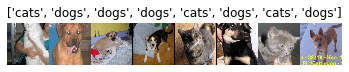

Prediction:


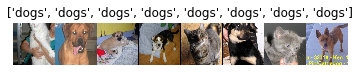

In [20]:
visualize_model(vgg16) #test before training

In [25]:
def train_model(vgg, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()
    best_model_wts = copy.deepcopy(vgg.state_dict())
    best_acc = 0.0
    
    avg_loss = 0
    avg_acc = 0
    avg_loss_val = 0
    avg_acc_val = 0
    
    train_batches = len(dataloaders[TRAIN])
    val_batches = len(dataloaders[VAL])
    
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs))
        print('-' * 10)
        
        loss_train = 0
        loss_val = 0
        acc_train = 0
        acc_val = 0
        
        vgg.train(True)
        
        for i, data in enumerate(dataloaders[TRAIN]):
            if i % 100 == 0:
                print("\rTraining batch {}/{}".format(i, train_batches / 2), end='', flush=True)
                
            # Use half training dataset
            if i >= train_batches / 2:
                break
                
            inputs, labels = data
            
            #if use_gpu:
                #inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
            #    inputs, labels = torch.as_tensor(inputs.cuda()), torch.as_tensor(labels.cuda())                
            #else:
                #inputs, labels = Variable(inputs), Variable(labels)
            inputs, labels = torch.as_tensor(inputs), torch.as_tensor(labels)
            
            optimizer.zero_grad()
            
            outputs = vgg(inputs)
            
            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            loss_train += loss.data
            acc_train += torch.sum(preds == labels.data)
            
            del inputs, labels, outputs, preds
            torch.cuda.empty_cache()
        
        print()
        # * 2 as we only used half of the dataset
        avg_loss = loss_train * 2 / dataset_sizes[TRAIN]
        avg_acc = acc_train * 2 / dataset_sizes[TRAIN]
        
        vgg.train(False)
        vgg.eval()
        
        for i, data in enumerate(dataloaders[VAL]):
            if i % 100 == 0:
                print("\rValidation batch {}/{}".format(i, val_batches), end='', flush=True)
                
            inputs, labels = data
            
            #if use_gpu:
                #inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)
            #    inputs, labels = torch.as_tensor(inputs.cuda()), torch.as_tensor(labels.cuda())
            #else:
                #inputs, labels = Variable(inputs, volatile=True), Variable(labels, volatile=True)
            inputs, labels = torch.as_tensor(inputs), torch.as_tensor(labels)
            
            optimizer.zero_grad()
            
            outputs = vgg(inputs)
            
            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            
            loss_val += loss.data
            acc_val += torch.sum(preds == labels.data)
            
            del inputs, labels, outputs, preds
            torch.cuda.empty_cache()
        
        avg_loss_val = loss_val / dataset_sizes[VAL]
        avg_acc_val = acc_val / dataset_sizes[VAL]
        
        print()
        print("Epoch {} result: ".format(epoch))
        print("Avg loss (train): {:.4f}".format(avg_loss))
        print("Avg acc (train): {:.4f}".format(avg_acc))
        print("Avg loss (val): {:.4f}".format(avg_loss_val))
        print("Avg acc (val): {:.4f}".format(avg_acc_val))
        print('-' * 10)
        print()
        
        if avg_acc_val > best_acc:
            best_acc = avg_acc_val
            best_model_wts = copy.deepcopy(vgg.state_dict())
        
    elapsed_time = time.time() - since
    print()
    print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Best acc: {:.4f}".format(best_acc))
    
    vgg.load_state_dict(best_model_wts)
    return vgg

In [28]:
vgg16 = train_model(vgg16, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)
torch.save(vgg16.state_dict(), 'VGG16_cats_vs_dogs.pt')

Epoch 0/10
----------
Training batch 0/3.0
Validation batch 0/3
Epoch 0 result: 
Avg loss (train): 0.0069
Avg acc (train): 1.0000
Avg loss (val): 0.0127
Avg acc (val): 1.0000
----------

Epoch 1/10
----------
Training batch 0/3.0
Validation batch 0/3
Epoch 1 result: 
Avg loss (train): 0.0255
Avg acc (train): 1.0000
Avg loss (val): 0.0126
Avg acc (val): 1.0000
----------

Epoch 2/10
----------
Training batch 0/3.0
Validation batch 0/3
Epoch 2 result: 
Avg loss (train): 0.0152
Avg acc (train): 1.0000
Avg loss (val): 0.0095
Avg acc (val): 1.0000
----------

Epoch 3/10
----------
Training batch 0/3.0
Validation batch 0/3
Epoch 3 result: 
Avg loss (train): 0.0121
Avg acc (train): 1.0000
Avg loss (val): 0.0080
Avg acc (val): 1.0000
----------

Epoch 4/10
----------
Training batch 0/3.0
Validation batch 0/3
Epoch 4 result: 
Avg loss (train): 0.0112
Avg acc (train): 1.0000
Avg loss (val): 0.0071
Avg acc (val): 1.0000
----------

Epoch 5/10
----------
Training batch 0/3.0
Validation batch 0/3
E

In [29]:
eval_model(vgg16, criterion)

Evaluating model
----------
Test batch 0/3
Evaluation completed in 0m 13s
Avg loss (test): 0.0217
Avg acc (test): 0.0000
----------


Ground truth:


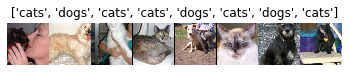

Prediction:


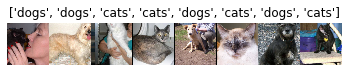

Ground truth:


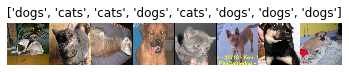

Prediction:


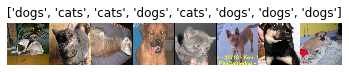

Ground truth:


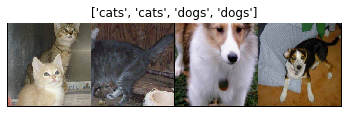

Prediction:


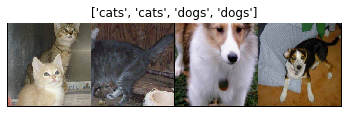

In [30]:
visualize_model(vgg16, num_images=32)